# Notebook for Embedding the cleaned and preprocessed tweets

#### If you're just interested in outputs, scroll down and load pre-trained

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec


In [3]:
# Load tweets
with open('../data/tweets_tokenized.pickle', 'rb') as f:
    tweets_tokenized = pickle.load(f)

## Training the W2V Model

- What are the hyperparameters?
- Which methods are used
- How is it trained?

Word2Vec takes a text corpus as an input and produces word vectors as output.
- First constructs a vocabulary from the training data
- Learns vector representation of words
- Word vectors can be used for deriving word classes by performing k-means clustering on top of the word vectors 

Inputs for ```Word2Vec```
- Sentences = Our tweets, in this case just a list
- Sg: Defines the trainig algorithm 0: CBOW, 1:Skip-gram
- Size: Dimensionality of the feature vector
- Window: Maximum distance between current and predicted word within sentence
- alpha: Initial learning rate
- min_count: Ignore all words with total frequency lower than this
- workers: Use this many workers to train the model
- hs: If 1, hierarchical softmax will be used for model training, 0: and negative is non-zero, negative sampling will be used
- negative:  if >0, negative sampling will be used, the integer specifies how many "noise words" should be drawn (usually between 5-20, default 5)
- cbow_mean: If 0, use the sum of the context word vectors  
- iter: Number of iterations over the corpus, default is 5
- trim_rule: Vocab trimming rule
- sorted_vocab: if 1 (default) sort the vocab by descending frequency before assigning word indexes
- batch_words: target size (in words) for batches of examples passed to worker threads

Inputs for ```Word2Vec.train()```


- training is done on the list of list where each entry is a tokenized tweet
- Train builds the vocabulary and trains the word2vec model

How does it work?
- Train a neural network with a hidden single layer where the goal is to predict the current word based on the context
- The goal is to learn the weights of the hidden layer, which are essentially the word vectors we're trying to learn

After training, we can discard the full model state and work just with the vectors.

### Detecting Phrases

First we automatically detect phrases like Donald Trump or Hillary Clinton using gensims Phrases model.

- Also a paper from the Word2Vec group!

https://arxiv.org/abs/1310.4546

In [4]:
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [5]:
# Import model
from gensim.models.phrases import Phrases, Phraser

In [6]:
# train
phrases = Phrases(tweets_tokenized, min_count=30, progress_per=500000)

INFO - 00:15:25: collecting all words and their counts
INFO - 00:15:25: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 00:15:32: PROGRESS: at sentence #500000, processed 3669343 words and 1689657 word types
INFO - 00:15:39: PROGRESS: at sentence #1000000, processed 7321675 words and 2813083 word types
INFO - 00:15:46: PROGRESS: at sentence #1500000, processed 10974881 words and 3736305 word types
INFO - 00:15:52: PROGRESS: at sentence #2000000, processed 14625667 words and 4536734 word types
INFO - 00:16:00: PROGRESS: at sentence #2500000, processed 18277736 words and 5256368 word types
INFO - 00:16:00: collected 5306633 word types from a corpus of 18542741 words (unigram + bigrams) and 2536417 sentences
INFO - 00:16:00: using 5306633 counts as vocab in Phrases<0 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>


In [7]:
# Make bigrams
bigram = Phraser(phrases)

INFO - 00:16:11: source_vocab length 5306633
INFO - 00:17:05: Phraser built with 16614 phrasegrams


In [8]:
# Making the corpus
tweets_clean =  bigram[tweets_tokenized]

### W2V Model

### CBOW vs Skip-gram and window size.

- CBOW predicts a word based on its neighbors
- Skip-gram predicts the neighbors of a word
- Skip-gram thus learns more the context or domain, while CBOW is better suited for finding similar words
- I think for our context skip-gram with a relatively large window (5-10) should be better to understand in which context each of the words is used
- If the context of Trump is markedly different from Hillary, then we should see that using skip-gram


In [9]:
# Average tweet length
np.mean([len(t) for t in tweets_tokenized])

7.310604289436634

Average number of words in the tweets is 7. So a window of 4 should capture the whole tweet. (I think skip-gram downweighs importance of words that are farther away?).

In [12]:
# Skip-gram model, without building vocabulary yet
w2v_model = Word2Vec(size=100, # layers of Neural Network, same as dimensionality of output
             alpha = 0.025, # Initial learning rate
             window=4, # Window size for context
             sg = 1, #Model 0: CBOW, 1: Skip-gram, trying with skip-gram here
             min_count=100, # I'm fairly conservative here to remove misspellings!
             sample = 1e-4, # Downsample frequent words, is akin to removing stop words, lower values are stricter!
             workers=8, # Nr of threads to train
             negative = 5, # Nr of noise words
             iter = 5)

# Building the vocabulary
w2v_model.build_vocab(tweets_clean, progress_per=500000)

# Training the model
w2v_model.train(tweets_tokenized, total_examples=w2v_model.corpus_count, epochs=5, report_delay=1)

# Save the model
w2v_model.save(f"../models/w2v_skipgram_w4.model")

INFO - 00:21:44: collecting all words and their counts
INFO - 00:21:44: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 00:21:55: PROGRESS: at sentence #500000, processed 3293000 words, keeping 124809 word types
INFO - 00:22:08: PROGRESS: at sentence #1000000, processed 6578497 words, keeping 171770 word types
INFO - 00:22:20: PROGRESS: at sentence #1500000, processed 9864873 words, keeping 207260 word types
INFO - 00:22:33: PROGRESS: at sentence #2000000, processed 13148889 words, keeping 236661 word types
INFO - 00:22:45: PROGRESS: at sentence #2500000, processed 16433370 words, keeping 262933 word types
INFO - 00:22:46: collected 264798 word types from a corpus of 16672129 raw words and 2536417 sentences
INFO - 00:22:46: Loading a fresh vocabulary
INFO - 00:22:46: effective_min_count=100 retains 17972 unique words (6% of original 264798, drops 246826)
INFO - 00:22:46: effective_min_count=100 leaves 14567577 word corpus (87% of original 16672129, drops 210455

INFO - 00:23:51: EPOCH 2 - PROGRESS: at 88.17% examples, 382324 words/s, in_qsize 15, out_qsize 0
INFO - 00:23:52: EPOCH 2 - PROGRESS: at 91.30% examples, 382146 words/s, in_qsize 13, out_qsize 2
INFO - 00:23:53: EPOCH 2 - PROGRESS: at 94.54% examples, 382783 words/s, in_qsize 15, out_qsize 0
INFO - 00:23:54: EPOCH 2 - PROGRESS: at 97.51% examples, 382656 words/s, in_qsize 15, out_qsize 0
INFO - 00:23:54: worker thread finished; awaiting finish of 7 more threads
INFO - 00:23:54: worker thread finished; awaiting finish of 6 more threads
INFO - 00:23:54: worker thread finished; awaiting finish of 5 more threads
INFO - 00:23:54: worker thread finished; awaiting finish of 4 more threads
INFO - 00:23:54: worker thread finished; awaiting finish of 3 more threads
INFO - 00:23:54: worker thread finished; awaiting finish of 2 more threads
INFO - 00:23:54: worker thread finished; awaiting finish of 1 more threads
INFO - 00:23:54: worker thread finished; awaiting finish of 0 more threads
INFO - 0

INFO - 00:25:01: worker thread finished; awaiting finish of 5 more threads
INFO - 00:25:01: worker thread finished; awaiting finish of 4 more threads
INFO - 00:25:01: worker thread finished; awaiting finish of 3 more threads
INFO - 00:25:01: worker thread finished; awaiting finish of 2 more threads
INFO - 00:25:01: worker thread finished; awaiting finish of 1 more threads
INFO - 00:25:01: worker thread finished; awaiting finish of 0 more threads
INFO - 00:25:01: EPOCH - 4 : training on 18542741 raw words (12861731 effective words) took 33.4s, 384507 effective words/s
INFO - 00:25:02: EPOCH 5 - PROGRESS: at 2.85% examples, 363488 words/s, in_qsize 15, out_qsize 0
INFO - 00:25:03: EPOCH 5 - PROGRESS: at 5.81% examples, 369050 words/s, in_qsize 15, out_qsize 0
INFO - 00:25:04: EPOCH 5 - PROGRESS: at 8.87% examples, 376857 words/s, in_qsize 15, out_qsize 0
INFO - 00:25:05: EPOCH 5 - PROGRESS: at 11.93% examples, 379205 words/s, in_qsize 15, out_qsize 0
INFO - 00:25:06: EPOCH 5 - PROGRESS: 

### Exploring outputs of embeddings

In [3]:
# Reload model 
w2v_model  = Word2Vec.load("../models/w2v_skipgram_w4.model")

In [4]:
# Just keep precomputed vectors
w2v_model.init_sims(replace=True)

In [5]:
from utils.comparison import get_most_similar

models = [w2v_model]

model_names = ['Skip Gram']

In [6]:
get_most_similar(models,"trump",n_similar=10, model_names=model_names)

Most similar words per model for word: trump


,Skip Gram - Word,Skip Gram - Similarity
0,donald,0.896358
1,trumps,0.791140
2,pres,0.770282
3,feedly,0.762091
4,illegitimate,0.755011
5,president,0.742422
6,trum,0.736769
7,administration,0.728688
8,donaldtrump,0.728006
9,rnc,0.725931


In [16]:
get_most_similar(models,"donald_trump",n_similar=10, model_names=model_names)

Most similar words per model for word: donald_trump


,Skip Gram - Word,Skip Gram - Similarity
0,melania_trump,0.913523
1,make_money,0.908309
2,sean_spicer,0.905902
3,aaron_hernandez,0.900620
4,la_la,0.897225
5,nigel_farage,0.890334
6,las_vegas,0.888912
7,white_house,0.885947
8,2016_election,0.885862
9,santa_barbara,0.884849


In [7]:
get_most_similar(models,"clinton",n_similar=10, model_names=model_names)

Most similar words per model for word: clinton


,Skip Gram - Word,Skip Gram - Similarity
0,hillary,0.935136
1,hillaryclinton,0.783674
2,clintons,0.781306
3,hrc,0.765259
4,campaign,0.741458
5,sanders,0.738335
6,emails,0.724602
7,crookedhillary,0.723004
8,hillarys,0.721376
9,billclinton,0.717722


In [18]:
get_most_similar(models,"sanders",n_similar=10, model_names=model_names)

Most similar words per model for word: sanders


,Skip Gram - Word,Skip Gram - Similarity
0,bernie,0.891267
1,clinton,0.738335
2,caucuses,0.735310
3,democratic,0.703262
4,delegates,0.686254
5,hillary,0.682518
6,berniesanders,0.681937
7,primary,0.679528
8,malley,0.677264
9,suppoers,0.653194


In [29]:
get_most_similar(models,"russia",n_similar=10, model_names=model_names)

Most similar words per model for word: russia


,Skip Gram - Word,Skip Gram - Similarity
0,russian,0.840399
1,putin,0.830774
2,meddling,0.812936
3,interference,0.811977
4,kremlin,0.796493
5,collusion,0.794644
6,russians,0.778914
7,colluded,0.765595
8,trumprussia,0.764843
9,colluding,0.763210


In [30]:
get_most_similar(models,"dnc",n_similar=10, model_names=model_names)

Most similar words per model for word: dnc


,Skip Gram - Word,Skip Gram - Similarity
0,dncleaks,0.793856
1,sethrich,0.752307
2,dncleak,0.736866
3,wikileaks,0.736354
4,podesta,0.733175
5,colluded,0.718254
6,podestaemails,0.695742
7,hillary,0.683261
8,schultz,0.682104
9,hrc,0.681093


In [31]:
get_most_similar(models,"rnc",n_similar=10, model_names=model_names)

Most similar words per model for word: rnc


,Skip Gram - Word,Skip Gram - Similarity
0,campaign,0.737262
1,trump,0.725931
2,fec,0.724749
3,republican,0.698081
4,gop,0.693239
5,clinton,0.691404
6,donald,0.668286
7,wh,0.658502
8,dnc,0.658034
9,priebus,0.654263


In [32]:
get_most_similar(models,"republican",n_similar=10, model_names=model_names)

Most similar words per model for word: republican


,Skip Gram - Word,Skip Gram - Similarity
0,gop,0.915800
1,democratic,0.827757
2,democrat,0.787232
3,dem,0.779586
4,republicans,0.755805
5,establishment,0.738279
6,debate,0.727369
7,democrats,0.723869
8,candidate,0.721619
9,candidates,0.720943


In [33]:
get_most_similar(models,"democrat",n_similar=10, model_names=model_names)

Most similar words per model for word: democrat


,Skip Gram - Word,Skip Gram - Similarity
0,dem,0.855282
1,democratic,0.789744
2,republican,0.787232
3,democrats,0.771444
4,dems,0.756351
5,ossoff,0.733773
6,illegitimate,0.721017
7,gop,0.710186
8,candidate,0.702210
9,establishment,0.689336


In [34]:
get_most_similar(models,"liberal",n_similar=10, model_names=model_names)

Most similar words per model for word: liberal


,Skip Gram - Word,Skip Gram - Similarity
0,leftist,0.844711
1,liberals,0.800079
2,lib,0.793328
3,libtard,0.772492
4,elitist,0.770209
5,leftists,0.767796
6,libs,0.765834
7,msm,0.752870
8,hypocritical,0.744076
9,fakenewsmedia,0.741612


In [35]:
get_most_similar(models,"conservative",n_similar=10, model_names=model_names)

Most similar words per model for word: conservative


,Skip Gram - Word,Skip Gram - Similarity
0,conservatives,0.760171
1,liberal,0.700967
2,establishment,0.694517
3,republican,0.663298
4,cruz2016,0.655790
5,outsider,0.655283
6,gop,0.645559
7,lib,0.642008
8,grassroots,0.641870
9,progressive,0.641821


In [36]:
get_most_similar(models,"islam",n_similar=10, model_names=model_names)

Most similar words per model for word: islam


,Skip Gram - Word,Skip Gram - Similarity
0,muslims,0.837124
1,bansharia,0.817536
2,christianity,0.812463
3,religionofpeace,0.809293
4,islamistheproblem,0.805156
5,radical,0.802823
6,infidels,0.793603
7,crusades,0.791683
8,muslim,0.791138
9,banislam,0.790276


In [37]:
get_most_similar(models,"christian",n_similar=10, model_names=model_names)

Most similar words per model for word: christian


,Skip Gram - Word,Skip Gram - Similarity
0,atheist,0.717415
1,christians,0.673261
2,evangelicals,0.664359
3,catholic,0.655283
4,christianity,0.647251
5,muslim,0.626763
6,homosexuals,0.623521
7,evangelical,0.623268
8,radicals,0.621590
9,atheists,0.620053


In [38]:
get_most_similar(models,"cnn",n_similar=10, model_names=model_names)

Most similar words per model for word: cnn


,Skip Gram - Word,Skip Gram - Similarity
0,msnbc,0.857173
1,fakenews,0.786226
2,nytimes,0.783881
3,tapper,0.767049
4,abc,0.758147
5,wapo,0.750898
6,msm,0.742036
7,cnnblackmail,0.729306
8,cnnsotu,0.728701
9,repoer,0.726534


In [30]:
get_most_similar(models,"fox",n_similar=10, model_names=model_names)

Most similar words per model for word: fox


,Skip Gram Window 5 - Word,Skip Gram Window 5 - Similarity
0,nbc,0.589153
1,latest,0.588807
2,channel,0.583562
3,blasts,0.575391
4,timeline,0.570156
5,donald,0.567936
6,exclusive,0.566918
7,cnn,0.561388
8,msnbc,0.559085
9,debate,0.557972


In [31]:
get_most_similar(models,"rigged",n_similar=10, model_names=model_names)

Most similar words per model for word: rigged


,Skip Gram Window 5 - Word,Skip Gram Window 5 - Similarity
0,election,0.703757
1,election2016,0.667060
2,2008,0.648220
3,elections,0.645120
4,crookedhillary,0.634095
5,dnc,0.630256
6,voting,0.615970
7,polls,0.602949
8,hillaryclinton,0.596248
9,primary,0.590883


In [32]:
get_most_similar(models,"news",n_similar=10, model_names=model_names)

Most similar words per model for word: news


,Skip Gram Window 5 - Word,Skip Gram Window 5 - Similarity
0,mississippi,0.682712
1,repos,0.664712
2,latest,0.621217
3,lawsuit,0.619892
4,nbc,0.604391
5,declares,0.585359
6,repoed,0.571642
7,resigns,0.571096
8,conference,0.563831
9,state,0.556341


In [33]:
get_most_similar(models,"fakenews",n_similar=10, model_names=model_names)

Most similar words per model for word: fakenews


,Skip Gram Window 5 - Word,Skip Gram Window 5 - Similarity
0,msm,0.691991
1,media,0.655237
2,cnn,0.653830
3,crookedhillary,0.647150
4,frustrating,0.633908
5,collusion,0.633589
6,propaganda,0.633090
7,wikileaks,0.632001
8,liberal,0.623575
9,russia,0.606558


### Visualizing similar words in a low-dimensional subspace using PCA and TSNE

What is TSNE?
- T-distributed Stochastic Neighbor Embedding
- Nonlinear dimensionality reduction technique
- First t-sne constructs a probability distribution over pairs of high-dimensional objects in such a way that similar objects have a high probability of being picked
- dissimilar points have a small probability of being picked
- Second: t-sne defines another probability distribution over the points in a low-dimensional map
- The minimizes KL-Divergence between the two distributions with respect to the locations of the points in the map 

What do these plots show?
- In a lower dimensional subspace, which words are most similar to each other
- Closeness in this case is related to words being interchangebable in a context
- So if we see Trump and Donald together we know that these two words often appear in the same context
- That is why we don't see a clear separation between words like good and bad, which often appear in the same context but we see a separation between Trump and Clinton
- We always plot the two words of interest and the 10 most similar words.

In [8]:
from utils.comparison import plot_word_embeddings

starting PCA
Done with PCA


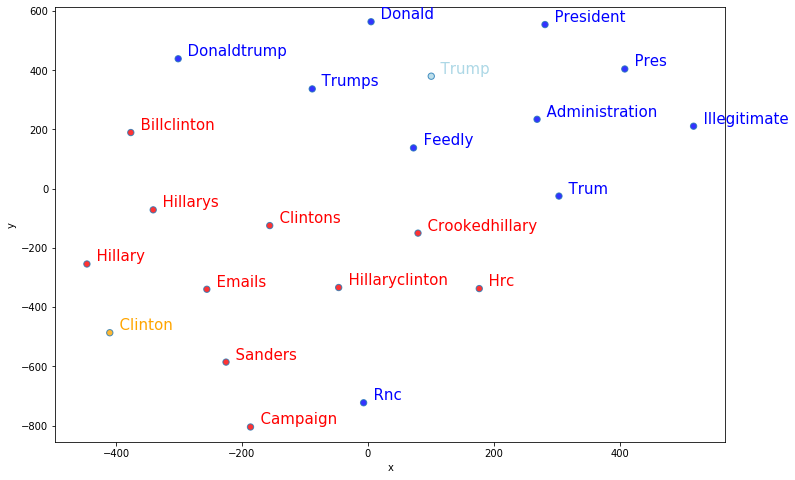

In [9]:
plot_word_embeddings("clinton", "trump", n_comparison =10, w2v_model =  w2v_model)
plt.savefig("../img/embedding_clinton_trump")

starting PCA
Done with PCA


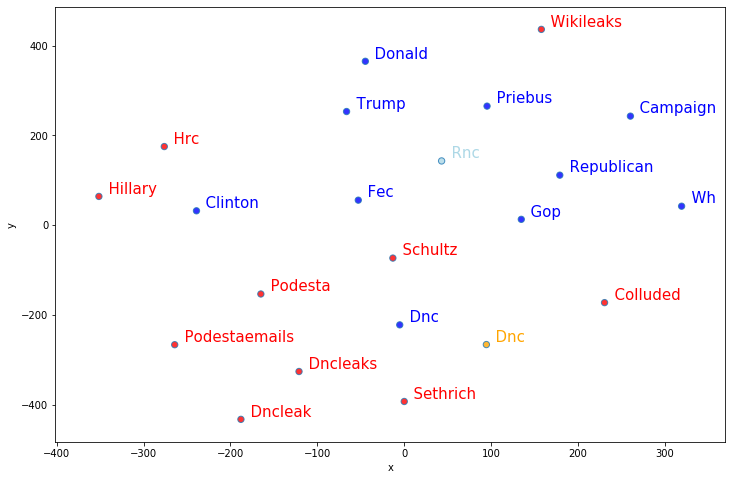

In [10]:
plot_word_embeddings("dnc", "rnc", n_comparison =10, w2v_model =  w2v_model)
plt.savefig("../img/embedding_dnc_rnc")

starting PCA
Done with PCA


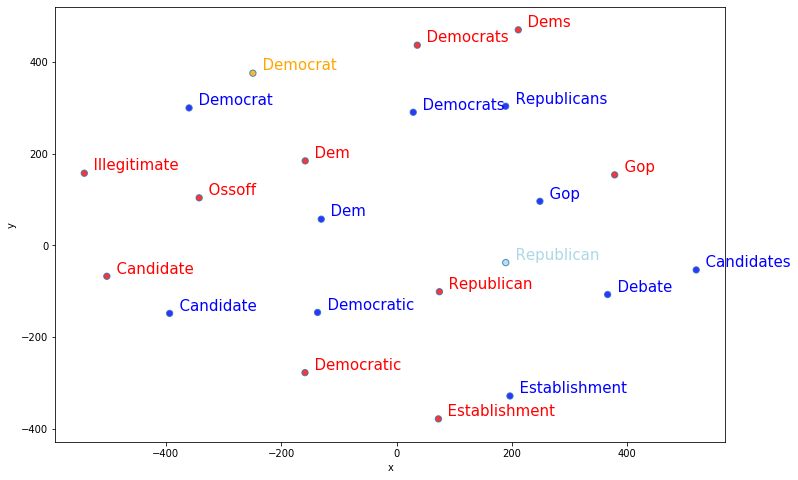

In [27]:
plot_word_embeddings("democrat", "republican", n_comparison =10, w2v_model =  w2v_model)

starting PCA
Done with PCA


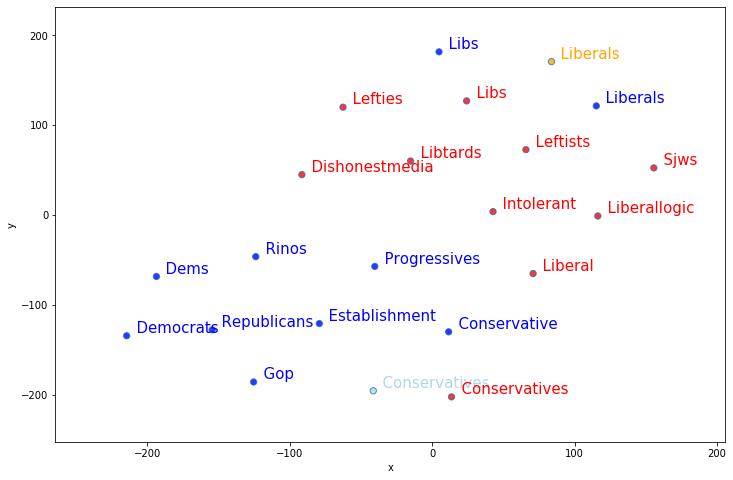

In [11]:
plot_word_embeddings("liberals", "conservatives", n_comparison =10, w2v_model =  w2v_model)
plt.savefig("../img/embedding_liberals_conservatives")

starting PCA
Done with PCA


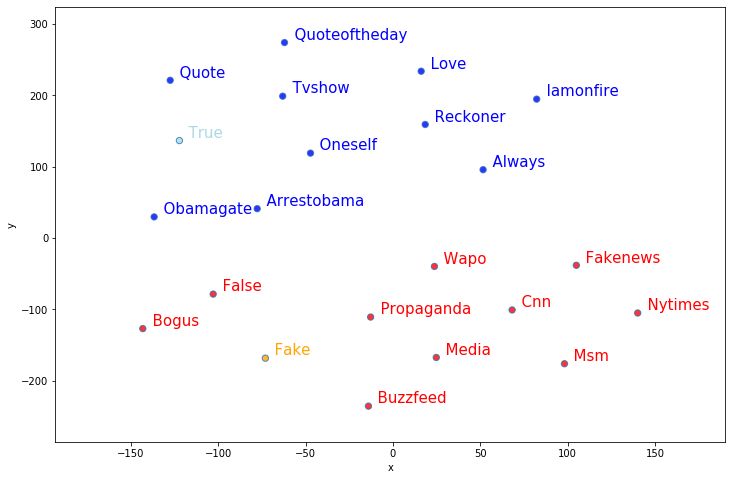

In [12]:
plot_word_embeddings("fake", "true", n_comparison =10, w2v_model =  w2v_model)
plt.savefig("../img/embedding_fake_true")

starting PCA
Done with PCA


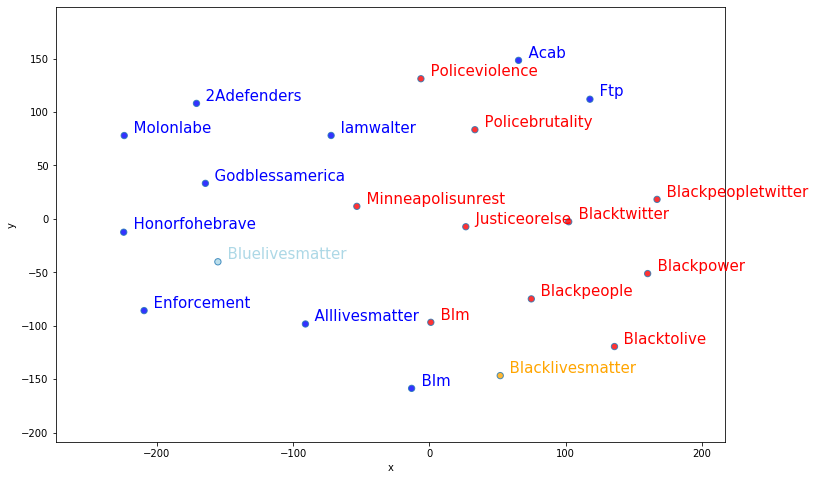

In [13]:
plot_word_embeddings("blacklivesmatter", "bluelivesmatter", n_comparison =10, w2v_model =  w2v_model)
plt.savefig("../img/embedding_blm")

starting PCA
Done with PCA


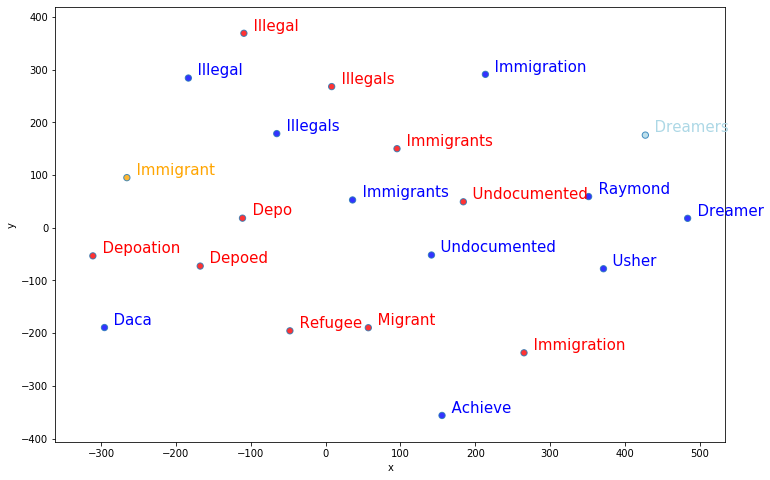

In [43]:
plot_word_embeddings("immigrant", "dreamers", n_comparison =10, w2v_model =  w2v_model)

starting PCA
Done with PCA


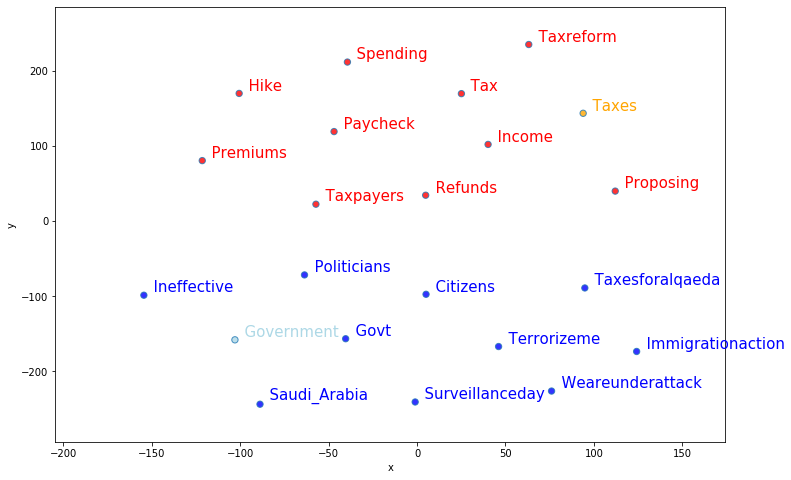

In [46]:
plot_word_embeddings("taxes", "government", n_comparison =10, w2v_model =  w2v_model)

starting PCA
Done with PCA


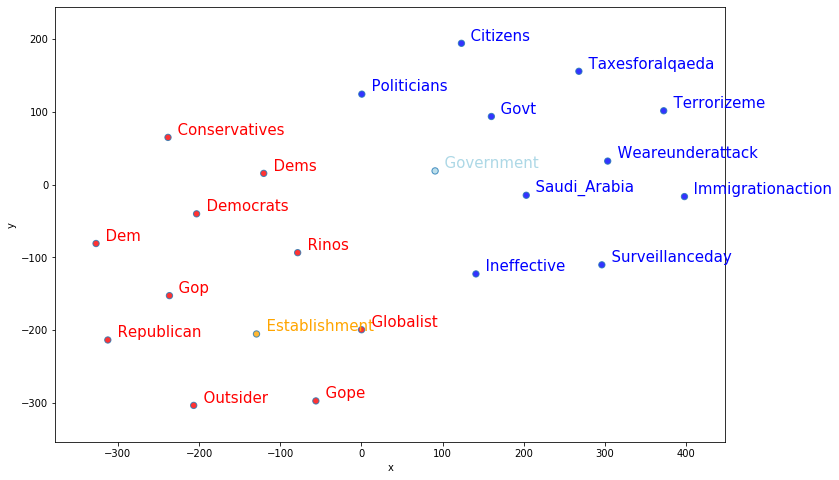

In [47]:
plot_word_embeddings("establishment", "government", n_comparison =10, w2v_model =  w2v_model)

starting PCA
Done with PCA


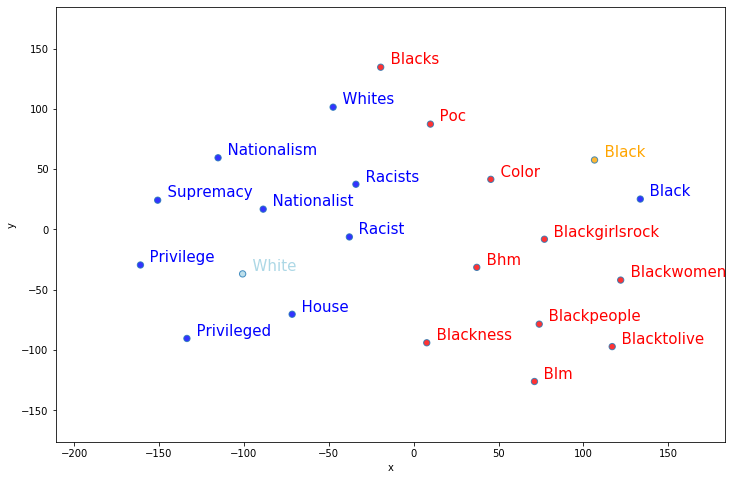

In [15]:
plot_word_embeddings("black", "white", n_comparison =10, w2v_model =  w2v_model)
plt.savefig("../img/embedding_black_white")

These visualizationsare awesome! We can clearly see how these tweets tried to generate negative connotations for certain words.
